## Hash Algorithm and Image Generator

In [12]:
from config import COLLECTION_DIR

# cat_path = imgs_path / "cat"
imgs_path = COLLECTION_DIR
robot_path = imgs_path / "robot"

robot_path


PosixPath('/windows10/Users/hamng/Desktop/projects/delicacy/images/robot')

### collection and image generator

In [13]:
from delicacy.igen.collection import Collection
from delicacy.igen.igen import ImageGenerator


In [14]:
# cat_collection = Collection("Cat", cat_path)
robot_collection = Collection("Robot", robot_path)
robot_collection


Collection(name='Robot', path=PosixPath('/windows10/Users/hamng/Desktop/projects/delicacy/images/robot'), layer_names=('000#Body', '001#Face', '002#Mouth', '003#Eyes', '004#Accessory'), layer_paths=['/windows10/Users/hamng/Desktop/projects/delicacy/images/robot/000#Body', '/windows10/Users/hamng/Desktop/projects/delicacy/images/robot/001#Face', '/windows10/Users/hamng/Desktop/projects/delicacy/images/robot/002#Mouth', '/windows10/Users/hamng/Desktop/projects/delicacy/images/robot/003#Eyes', '/windows10/Users/hamng/Desktop/projects/delicacy/images/robot/004#Accessory'])

In [15]:
phrase = "elonmusk"
width = height = 320

CPU times: user 17.1 ms, sys: 3.2 ms, total: 20.3 ms
Wall time: 20.3 ms


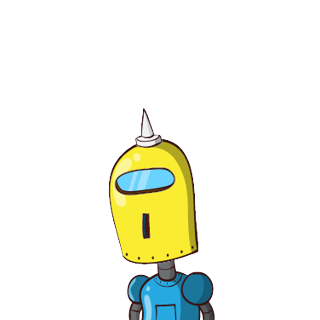

In [16]:
%%time

img_gen = ImageGenerator(robot_collection)
character = img_gen.generate(phrase, size=(width, height))
character

## Generative Art for Background

In [17]:
from delicacy.svglib.utils.utils import eprint, materialize, wand2pil
from delicacy.excite.excite import BGMaker, ExAid, Genm, ParaDX


In [18]:
SEED = 2109
colors = ["#3a86ff", "#ff006e", "#ffbe0b", "#0a9396"]

In [19]:
def combine(foreground, background):
    img = wand2pil(background)
    img.paste(foreground, (0, 0), foreground)
    return img

CPU times: user 75.4 ms, sys: 720 µs, total: 76.1 ms
Wall time: 72.6 ms


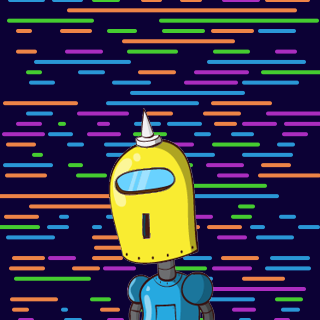

In [20]:
%%time

bgmaker = BGMaker(ExAid, seed=SEED)
canvas = bgmaker.generate(width, height)

background = materialize(canvas)
combine(character, background)

CPU times: user 109 ms, sys: 3.74 ms, total: 113 ms
Wall time: 125 ms


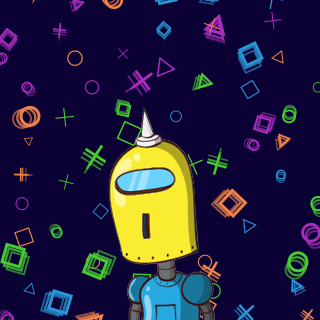

In [21]:
%%time

bgmaker = BGMaker(Genm, seed=SEED)
canvas = bgmaker.generate(width, height)

background = materialize(canvas)
combine(character, background)

CPU times: user 53.7 ms, sys: 6.56 ms, total: 60.2 ms
Wall time: 56.6 ms


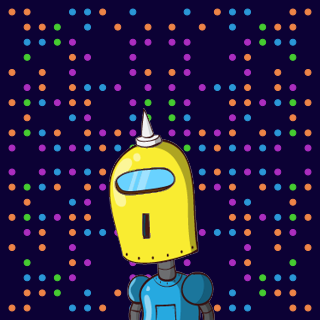

In [22]:
%%time

bgmaker = BGMaker(ParaDX, seed=SEED)
canvas = bgmaker.generate(width, height)

background = materialize(canvas)
combine(character, background)